In [204]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from mocsy import mocsy
import cmocean.cm as cm
from matplotlib import colors
from salishsea_tools import viz_tools
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


## Non-specific to month; do the clusters on all of the data, and then re-sort into months

Define Month

In [61]:
month_idxs = {
  'January': 0,
  'February': 1,
  'March': 2,
  'April': 3,
  'May': 4,
  'June': 5,
  'July': 6,
  'August': 7,
  'September': 8,
  'October': 9,
  'November': 10,
  'December': 11,
}

month = 'January'
month_idx = month_idxs[month]

In [175]:
month_list = list(month_idxs.keys())
short_months = [month[:3] + '.' for month in month_list]

In [63]:
colors_g = ['darkgrey', 'grey']  # Define colors for 0 and 1
custom_cmap = ListedColormap(colors_g)

In [64]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

coastline_mask = np.loadtxt('coastline_5m.csv', delimiter=',')
coastline_mask_tiled = np.tile(coastline_mask, (12, 1, 1))

In [65]:
def get_xyvals(array):
    valid_points = ~np.isnan(array)
    y, x = np.where(valid_points)  # Get coordinates of valid points
    values = array[valid_points]  # Get the actual values
    return x, y, values

In [66]:
def mocsy_simp(ii, ij, ji, jj, salinity_ds, temp_ds, TA_ds, DIC_ds):
    Tinsitu = np.array(gsw.t_from_CT(salinity_ds, temp_ds, 0))
    Spsu = 35/35.16504 * np.array(salinity_ds)
    TA = np.array(TA_ds)/1000.
    DIC = np.array(DIC_ds)/1000.

    ones = np.ones_like(Spsu.flatten())

    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pH, OmegaA

In [67]:
phys_mon = xr.open_dataset('phys_clim_2016_2023.nc')
chem_mon = xr.open_dataset('chem_clim_2016_2023.nc')

In [68]:
salinity = np.ma.masked_array(phys_mon.vosaline.to_numpy(), mask=coastline_mask_tiled)
temperature = np.ma.masked_array(phys_mon.votemper.to_numpy(), mask=coastline_mask_tiled)
TA = np.ma.masked_array(chem_mon.total_alkalinity.to_numpy(), mask=coastline_mask_tiled)
DIC = np.ma.masked_array(chem_mon.dissolved_inorganic_carbon.to_numpy(), mask=coastline_mask_tiled)

salinity_flat = salinity.flatten()
temperature_flat = temperature.flatten()
TA_flat = TA.flatten()
DIC_flat = DIC.flatten()

In [69]:
ph_flat, omegaA_flat = mocsy_simp(0, 898, 0, 398, salinity_flat, temperature_flat, TA_flat, DIC_flat)

In [70]:
ph_flat = np.ma.masked_array(ph_flat, mask=coastline_mask_tiled)
omegaA_flat = np.ma.masked_array(omegaA_flat, mask=coastline_mask_tiled)

In [71]:
# fig, axs = plt.subplots(2,3, figsize = (14,16), sharex=True, sharey=True)
# fig.suptitle('{} 2016-2023'.format('Mean'))

# # salinity
# x, y, salinity_vals = get_xyvals(salinity_flat.reshape(898, 398))
# axs[0,0].pcolormesh(tmask[0], cmap=custom_cmap)
# points = axs[0,0].scatter(x, y, c=salinity_vals, cmap=cm.haline, s=2)
# axs[0,0].set_title('Coastline Salinity Values')
# axs[0,0].set_xlabel('Grid X')
# axs[0,0].set_ylabel('Grid Y')
# fig.colorbar(points, ax=axs[0,0], label='salinity [g/kg]')
# axs[0,0].set_facecolor('grey')
# viz_tools.set_aspect(axs[0,0]);

# # temperature
# x, y, temperature_vals = get_xyvals(temperature_flat.reshape(898, 398))
# axs[0,1].pcolormesh(tmask[0], cmap=custom_cmap)
# points = axs[0,1].scatter(x, y, c=temperature_vals, cmap=cm.thermal, s=2)
# axs[0,1].set_title('Coastline Temperature Values')
# axs[0,1].set_xlabel('Grid X')
# axs[0,1].set_ylabel('Grid Y')
# fig.colorbar(points, ax=axs[0,1], label='Temp [deg C]]')
# axs[0,1].set_facecolor('grey')
# viz_tools.set_aspect(axs[0,1]);

# # total alkalinity
# x, y, TA_vals = get_xyvals(TA_flat.reshape(898, 398))
# axs[0,2].pcolormesh(tmask[0], cmap=custom_cmap)
# points = axs[0,2].scatter(x, y, c=TA_vals, cmap=cm.amp, s=2)
# axs[0,2].set_title('Coastline Total Alkalinity Values')
# axs[0,2].set_xlabel('Grid X')
# axs[0,2].set_ylabel('Grid Y')
# fig.colorbar(points, ax=axs[0,2], label='TA [mmol m-3]')
# axs[0,2].set_facecolor('grey')
# viz_tools.set_aspect(axs[0,2]);

# # dissolved inorganic carbon
# x, y, DIC_vals = get_xyvals(DIC_flat.reshape(898, 398))
# axs[1,0].pcolormesh(tmask[0], cmap=custom_cmap)
# points = axs[1,0].scatter(x, y, c=DIC_vals, cmap=cm.matter, s=2)
# axs[1,0].set_title('Coastline Dissolved Inorganic Carbon Values')
# axs[1,0].set_xlabel('Grid X')
# axs[1,0].set_ylabel('Grid Y')
# fig.colorbar(points, ax=axs[1,0], label='DIC [mmol m-3]')
# axs[1,0].set_facecolor('grey')
# viz_tools.set_aspect(axs[1,0]);

# # aragonite saturation
# x, y, omegaA_vals = get_xyvals(omega_flat.reshape(898, 398))
# axs[1,1].pcolormesh(tmask[0], cmap=custom_cmap)
# points = axs[1,1].scatter(x, y, c=omegaA_vals, cmap=cm.balance, s=2, vmin=0, vmax=2)
# axs[1,1].set_title('Coastline Aragonite Saturation Values')
# axs[1,1].set_xlabel('Grid X')
# axs[1,1].set_ylabel('Grid Y')
# fig.colorbar(points, ax=axs[1,1], label=r'$\Omega_A$')
# axs[1,1].set_facecolor('grey')
# viz_tools.set_aspect(axs[1,1]);

# # pH
# x, y, ph_vals = get_xyvals(ph_flat.reshape(898, 398))
# axs[1,2].pcolormesh(tmask[0], cmap=custom_cmap)
# points = axs[1,2].scatter(x, y, c=ph_vals, cmap=cm.ice, s=2)
# axs[1,2].set_title('Coastline pH Values')
# axs[1,2].set_xlabel('Grid X')
# axs[1,2].set_ylabel('Grid Y')
# fig.colorbar(points, ax=axs[1,2], label=r'pH')
# axs[1,2].set_facecolor('grey')
# viz_tools.set_aspect(axs[1,2]);

## Clustering on Temperature, Salinity, and omegaA with equal weights

In [72]:
# Combine the flattened arrays into a single dataset
mask = np.isnan(salinity.filled(np.nan))
data = np.vstack((salinity_flat.filled(np.nan), temperature_flat.filled(np.nan), omegaA_flat.filled(np.nan))).T
data_clean = data[~np.isnan(data).any(axis=1)]

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_clean)

# Apply K-Means clustering
n_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# sort by the centroids
kmeans_fit = kmeans.fit(data_clean)
sorted_indices = np.argsort(kmeans_fit.cluster_centers_, axis=0)
sorted_indices = sorted_indices[:, 0]  # Sort by the first dimension
sorted_centroids = kmeans_fit.cluster_centers_[sorted_indices]

label_map = {old: new for new, old in enumerate(sorted_indices)}
sorted_labels = np.array([label_map[label] for label in kmeans_fit.labels_])

# clusters, sorted
# clusters = kmeans_fit.fit_predict(data_normalized)
clusters = sorted_labels

clusters_3d = np.full(salinity.shape, np.nan)
clusters_3d[~mask] = clusters

In [161]:
cmap = plt.cm.rainbow
norm_clusters = colors.BoundaryNorm(np.arange(-0.5, n_clusters, 1), cmap.N)
cluster_colors = cmap(norm_clusters(np.arange(6)))

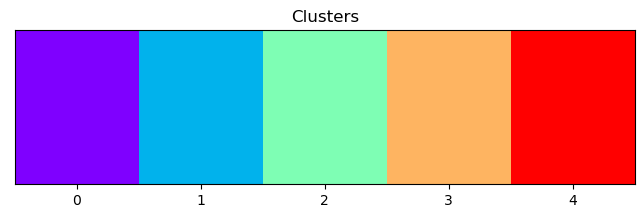

In [164]:
fig, ax = plt.subplots(figsize=(8, 2))

# Generate a 1-row image of colors
color_bar = np.arange(n_clusters).reshape(1, -1)  # Shape (1, n_clusters+1)

# Display the colors
ax.imshow(color_bar, aspect="auto", cmap=cmap, norm=norm_clusters)

# Set x-ticks to show classification labels
ax.set_xticks(np.arange(n_clusters))
ax.set_xticklabels(np.arange(n_clusters))
ax.set_yticks([])  # Remove y-axis

ax.set_title('Clusters')
plt.show()

In [160]:
cmap_12 = plt.cm.viridis
norm_months = colors.BoundaryNorm(np.arange(-0.5, 13, 1), cmap_12.N)
month_colors = cmap_12(norm_months(np.arange(12)))

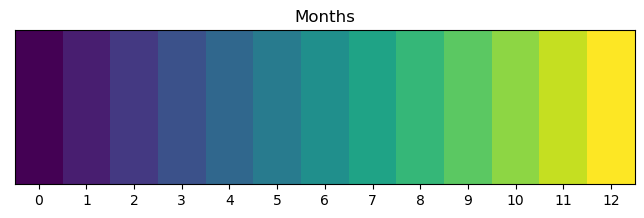

In [165]:
fig, ax = plt.subplots(figsize=(8, 2))

# Generate a 1-row image of colors
color_bar = np.arange(13).reshape(1, -1)  # Shape (1, 13)

# Display the colors
ax.imshow(color_bar, aspect="auto", cmap=cmap_12, norm=norm_months)

# Set x-ticks to show classification labels
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.set_yticks([])  # Remove y-axis

ax.set_title('Months')
plt.show()

In [74]:
salinity_vals_only = salinity_flat.filled(np.nan)[~mask.flatten()]
temperature_vals_only = temperature_flat.filled(np.nan)[~mask.flatten()]
omegaA_vals_only = omegaA_flat.filled(np.nan)[~mask.flatten()]

param_vals = [salinity_vals_only, temperature_vals_only, omegaA_vals_only]

In [75]:
salinity_means = np.zeros(n_clusters)
temperature_means = np.zeros(n_clusters)
omegaA_means = np.zeros(n_clusters)

sal_as_clusters = list()
temp_as_clusters = list()
omegaA_as_clusters = list()

for i in range(n_clusters):
    sal_mean = salinity_vals_only[clusters == i].mean()
    salinity_means[i] = sal_mean

    temp_mean = temperature_vals_only[clusters == i].mean()
    temperature_means[i] = temp_mean

    omegaA_mean = omegaA_vals_only[clusters == i].mean()
    omegaA_means[i] = omegaA_mean

    sal_as_clusters.append(salinity_vals_only[clusters == i])
    temp_as_clusters.append(temperature_vals_only[clusters == i])
    omegaA_as_clusters.append(omegaA_vals_only[clusters == i])

list_of_params = [sal_as_clusters, temp_as_clusters, omegaA_as_clusters]

## Cluster Map

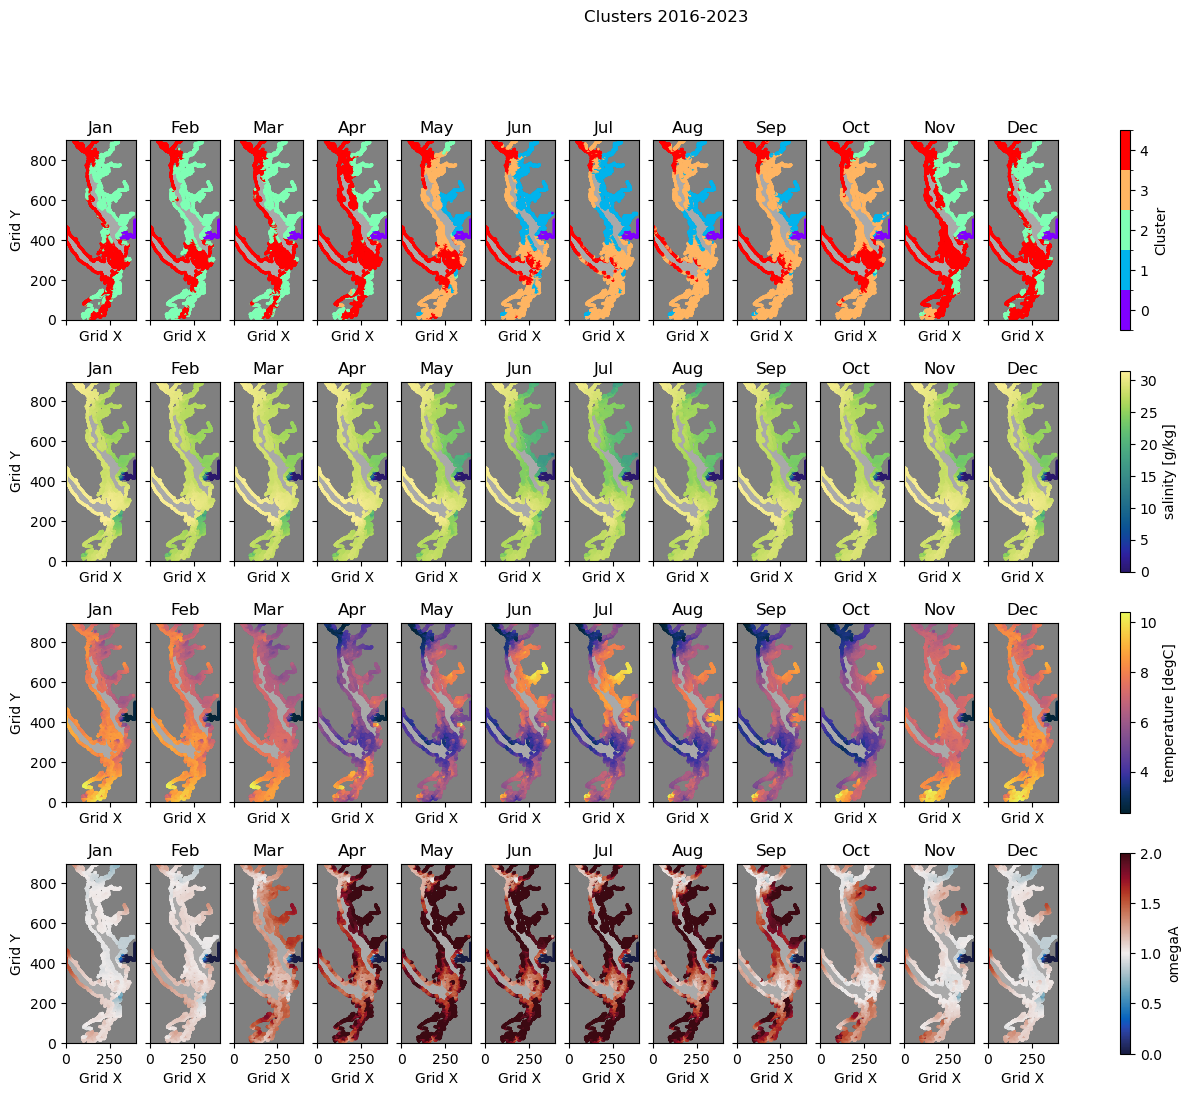

In [ ]:
fig, ax = plt.subplots(4,12, figsize = (16,12), sharex=True, sharey=True)
fig.suptitle('{} 2016-2023 COLORBARS WRONG ON THIS'.format('Clusters'))

cluster_vals_months = []
for i in np.arange(12):
    x, y, cluster_vals = get_xyvals(clusters_3d[i, :, :])
    cluster_vals_months = cluster_vals_months + [cluster_vals]
    # x, y, cluster_vals = get_xyvals(clusters[i, :, :])
    ax[0,i].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[0,i].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm_clusters, s=1)
    ax[0,i].set_title('{}'.format(month_list[i][0:3]))
    ax[0,i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[0,i]);

ax[0,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[0,:], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')
clusters_months_flat = np.array(cluster_vals_months).flatten()

for i in np.arange(12):
    x, y, salinity_vals = get_xyvals(salinity_flat.reshape(12, 898, 398)[i])
    ax[1,i].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[1,i].scatter(x, y, c=salinity_vals, cmap=cm.haline, s=1)
    ax[1,i].set_title('{}'.format(month_list[i][0:3]))
    ax[1,i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[1,i]);

ax[1,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[1,:], label='salinity [g/kg]')

for i in np.arange(12):
    x, y, temperature_vals = get_xyvals(temperature_flat.reshape(12, 898, 398)[i])
    ax[2,i].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[2,i].scatter(x, y, c=temperature_vals, cmap=cm.thermal, s=1)
    ax[2,i].set_title('{}'.format(month_list[i][0:3]))
    ax[2,i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[2,i]);

ax[2,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[2,:], label='temperature [degC]')

for i in np.arange(12):
    x, y, omegaA_vals = get_xyvals(omegaA_flat.reshape(12, 898, 398)[i])
    ax[3,i].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[3,i].scatter(x, y, c=omegaA_vals, cmap=cm.balance, vmin=0, vmax=2, s=1)
    ax[3,i].set_title('{}'.format(month_list[i][0:3]))
    ax[3,i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[3,i]);

ax[3,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[3,:], label='omegaA')


In [115]:
nan_mask = np.isnan(clusters_3d)  # Boolean mask where data is NaN
valid_mask = ~np.all(nan_mask, axis=0)  # True if at least one valid value exists

In [119]:
class_counts = {}

In [121]:
for i in range(5):
    counts = np.sum(clusters_3d == i, axis=0).astype(float)  # Count occurrences of each class
    counts[~valid_mask] = np.nan  # Set locations that were always NaN to NaN
    class_counts[i] = counts  # Store in dictionary

In [122]:
class_counts[0].shape

(898, 398)

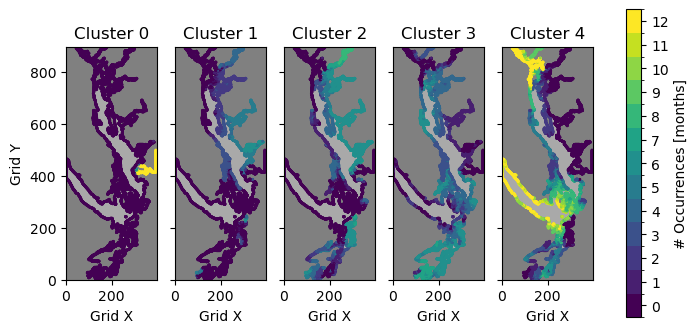

In [166]:
fig, ax = plt.subplots(1,5, figsize = (8.5,4), sharex=True, sharey=True)

for i in range(5):
    x, y, cluster_counts = get_xyvals(class_counts[i])
    ax[i].pcolormesh(tmask[i], cmap=custom_cmap)
    points = ax[i].scatter(x, y, c=cluster_counts, cmap=cmap_12, norm=norm_months, s=1)
    ax[i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[i]);
    ax[i].set_title('Cluster {}'.format(i))


ax[0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[:], ticks=np.linspace(0, 13-1, 13), label='# Occurrences [months]')

In [82]:
clust_data = np.nan_to_num(clusters_3d, nan=999)

all_possible_values = np.arange(clust_data.min(), clust_data.max() + 1)

unique_and_counts_normalized = []
counts_list = []
for i in range(clust_data.shape[0]):
    unique_values, counts = np.unique(clust_data[i], return_counts=True)
    full_counts = np.zeros_like(all_possible_values, dtype=int)
    full_counts[np.isin(all_possible_values, unique_values)] = counts
    counts_list.append(full_counts)
    unique_and_counts_normalized.append((all_possible_values, full_counts))

/home/cdonaldson/conda_envs/analysis-cassidy/lib/python3.10/site-packages/matplotlib/axis.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


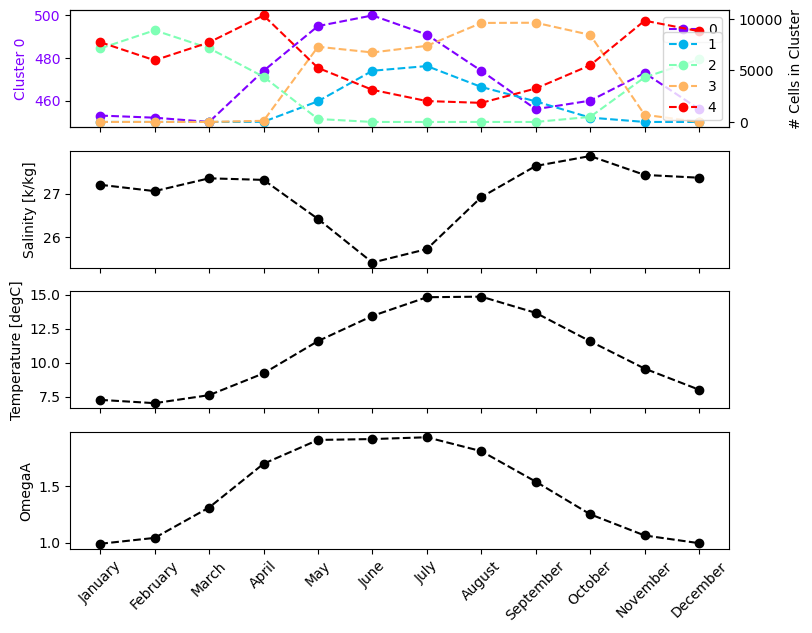

In [83]:
fig, ax1 = plt.subplots(4,1,  figsize = (8.5,7), sharex=True)

ax1[0].plot(month_list, np.array(counts_list)[:,0], color=cluster_colors[0], label='0', marker='o', linestyle='--')
ax1[0].tick_params(axis='y', labelcolor=cluster_colors[0])
ax1[0].set_ylabel('Cluster 0', color=cluster_colors[0])

ax2 = ax1[0].twinx()
ax2.plot(month_list, np.array(counts_list)[:,1], color=cluster_colors[1], label='1', marker='o', linestyle='--')
ax2.plot(month_list, np.array(counts_list)[:,2], color=cluster_colors[2], label='2', marker='o', linestyle='--')
ax2.plot(month_list, np.array(counts_list)[:,3], color=cluster_colors[3], label='3', marker='o', linestyle='--')
ax2.plot(month_list, np.array(counts_list)[:,4], color=cluster_colors[4], label='4', marker='o', linestyle='--')
ax2.set_ylabel('# Cells in Cluster')

ax1[0].legend()
ax2.legend()

ax1[1].plot(month_list, np.array(salinity.mean(axis=2).mean(axis=1)), color='k', marker='o', linestyle='--')
ax1[1].set_ylabel('Salinity [k/kg]')

ax1[2].plot(month_list, np.array(temperature.mean(axis=2).mean(axis=1)), color='k', marker='o', linestyle='--')
ax1[2].set_ylabel('Temperature [degC]')

ax1[3].plot(month_list, np.array(omegaA_flat.reshape(12, 898, 398).mean(axis=2).mean(axis=1)), color='k', marker='o', linestyle='--')
ax1[3].set_ylabel('OmegaA')
ax1[3].tick_params(axis='x', labelrotation=45)

## Combine cluster occurance plots

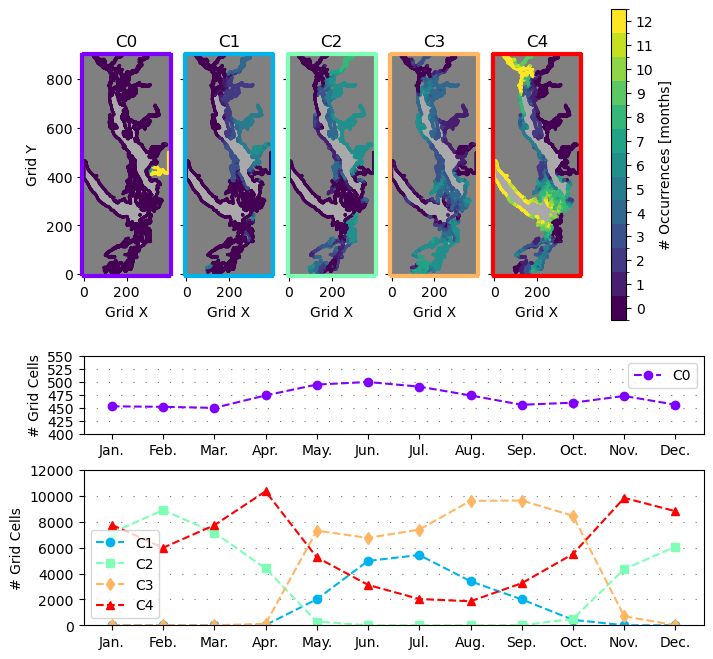

In [272]:
fig = plt.figure(figsize = (8,8))
gs = gridspec.GridSpec(3, 5, height_ratios=[1, 0.25, 0.5])  # 2 rows, 5 columns
ax_ref = fig.add_subplot(gs[0, 0])
axes_top = [ax_ref] + [fig.add_subplot(gs[0, i], sharex=ax_ref) for i in range(1, 5)]
ax_bottom_1 = fig.add_subplot(gs[1, :])  # Span all 5 columns
ax_bottom_2 = fig.add_subplot(gs[2, :])  # Span all 5 columns

# Hide the y-tick labels for all subplots in the top row except for the first one
for ax in axes_top[1:]:
    ax.set_yticklabels([])  # Hides the y-tick labels

for i in range(5):
    x, y, cluster_counts = get_xyvals(class_counts[i])
    axes_top[i].pcolormesh(tmask[i], cmap=custom_cmap)
    points = axes_top[i].scatter(x, y, c=cluster_counts, cmap=cmap_12, norm=norm_months, s=1)
    axes_top[i].set_xlabel('Grid X')
    viz_tools.set_aspect(axes_top[i]);
    axes_top[i].set_title('C{}'.format(i))
    axes_top[i].set_facecolor('papayawhip')
    for spine in axes_top[i].spines.values():
        spine.set_edgecolor(cluster_colors[i])
        spine.set_linewidth(3)
        spine.set_position(('outward', 1))

axes_top[0].set_ylabel('Grid Y')
fig.colorbar(points, ax=axes_top[:], ticks=np.linspace(0, 13-1, 13), label='# Occurrences [months]')

# # Define the color and properties for the large box
# box_color = 'papayawhip'  # Color of the background box
# linewidth = 2  # Line width of the box

# # Get the extent (position) of the top row of subplots
# x0, y0 = axes_top[0].get_position().get_points()[0]  # bottom-left corner of first subplot
# x1, y1 = axes_top[-1].get_position().get_points()[1]  # top-right corner of last subplot

# # Add a rectangle around the top row
# fig.patches.append(
#     patches.Rectangle(
#         (x0, y0),  # bottom-left corner
#         x1 - x0,    # width
#         y1 - y0,    # height
#         linewidth=linewidth,
#         edgecolor='black',  # Border color
#         facecolor=box_color,  # Fill color
#         zorder=0  # Ensure it's behind the subplots
#     )
# )


ax_bottom_1.plot(short_months, np.array(counts_list)[:,0], color=cluster_colors[0], label='C0', marker='o', linestyle='--')
# ax_bottom_1.tick_params(axis='y', labelcolor=cluster_colors[0])
ax_bottom_1.set_ylabel('# Grid Cells')
ax_bottom_1.set_ylim([400,550])
ax_bottom_1.set_yticks(np.arange(400,550+25,25))
ax_bottom_1.legend()
ax_bottom_1.grid(axis='y', color='#737373', linestyle=(0, (1, 10)))

ax_bottom_2.plot(short_months, np.array(counts_list)[:,1], color=cluster_colors[1], label='C1', marker='o', linestyle='--')
ax_bottom_2.plot(short_months, np.array(counts_list)[:,2], color=cluster_colors[2], label='C2', marker='s', linestyle='--')
ax_bottom_2.plot(short_months, np.array(counts_list)[:,3], color=cluster_colors[3], label='C3', marker='d', linestyle='--')
ax_bottom_2.plot(short_months, np.array(counts_list)[:,4], color=cluster_colors[4], label='C4', marker='^', linestyle='--')
ax_bottom_2.set_ylabel('# Grid Cells')
ax_bottom_2.set_ylim([0,10750])
ax_bottom_2.set_yticks(np.arange(0,11000+2000,2000))
ax_bottom_2.legend(loc='lower left')
ax_bottom_2.grid(axis='y', color='#737373', linestyle=(0, (1, 10)))


I'm seeing from this that July and January are good representative months for the two states? And the transitions would be April and October.

In [218]:
month_sel = np.arange(0,9+3,3)
month_sel

array([0, 3, 6, 9])

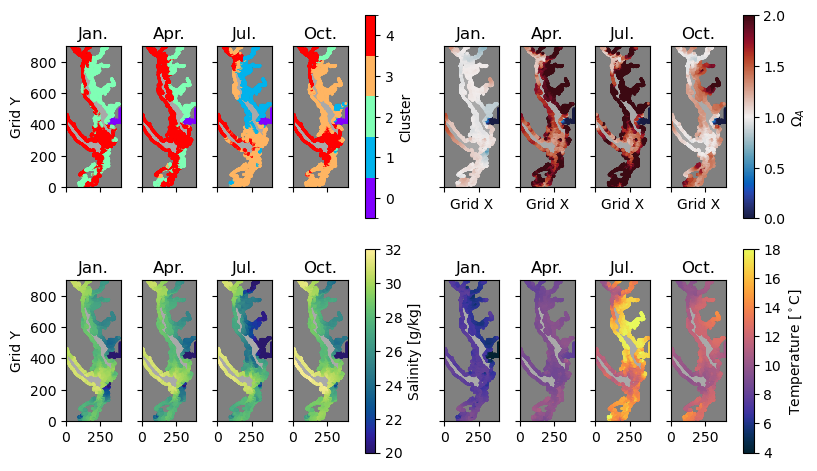

In [273]:
fig, ax = plt.subplots(2,8, figsize = (8,5), sharex=True, sharey=True)
fig.tight_layout(pad=1.2)

## CLusters
for i in np.arange(4):
    x, y, cluster_vals = get_xyvals(clusters_3d[month_sel[i], :, :])
    # cluster_vals_months = cluster_vals_months + [cluster_vals]
    # x, y, cluster_vals = get_xyvals(clusters[i, :, :])
    ax[0,i].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[0,i].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm_clusters, s=1)
    ax[0,i].set_title('{}'.format(short_months[month_sel[i]]))
    # ax[0,i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[0,i]);

ax[0,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[0,0:4], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

## Aragonite Saturation
for i in np.arange(4):
    x, y, omegaA_vals = get_xyvals(omegaA_flat.reshape(12, 898, 398)[month_sel[i]])
    norm_omegaA = colors.Normalize(vmin=0, vmax=2)
    ax[0,i+4].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[0,i+4].scatter(x, y, c=omegaA_vals, cmap=cm.balance, s=1, norm=norm_omegaA)
    ax[0,i+4].set_title('{}'.format(short_months[month_sel[i]]))
    ax[0,i+4].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[0,i+4]);

# ax[0,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[0,4:8], label=r'$\Omega_A$')

## Salinity
for i in np.arange(4):
    x, y, salinity_vals = get_xyvals(salinity_flat.reshape(12, 898, 398)[month_sel[i]])
    norm_sal = colors.Normalize(vmin=20, vmax=32)
    ax[1,i].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[1,i].scatter(x, y, c=salinity_vals, cmap=cm.haline, s=1, norm=norm_sal)
    ax[1,i].set_title('{}'.format(short_months[month_sel[i]]))
    # ax[1,i].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[1,i]);

ax[1,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[1,0:4], label='Salinity [g/kg]')

## Temperature
for i in np.arange(4):
    x, y, temperature_vals = get_xyvals(temperature_flat.reshape(12, 898, 398)[month_sel[i]])
    norm_temp = colors.Normalize(vmin=4, vmax=18)
    ax[1,i+4].pcolormesh(tmask[0], cmap=custom_cmap)
    points = ax[1,i+4].scatter(x, y, c=temperature_vals, cmap=cm.thermal, s=1, norm=norm_temp)
    ax[1,i+4].set_title('{}'.format(short_months[month_sel[i]]))
    # ax[1,i+4].set_xlabel('Grid X')
    viz_tools.set_aspect(ax[1,i+4]);

# ax[1,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=ax[1,4:8], label=r'Temperature [$^\circ$C]')



In [253]:
# fig, ax = plt.subplots(4,4, figsize = (8.5,11), sharex=True, sharey=True)

# ## CLusters
# for i in np.arange(4):
#     x, y, cluster_vals = get_xyvals(clusters_3d[month_sel[i], :, :])
#     # cluster_vals_months = cluster_vals_months + [cluster_vals]
#     # x, y, cluster_vals = get_xyvals(clusters[i, :, :])
#     ax[0,i].pcolormesh(tmask[0], cmap=custom_cmap)
#     points = ax[0,i].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm_clusters, s=1)
#     ax[0,i].set_title('{}'.format(short_months[month_sel[i]][0:3]))
#     # ax[0,i].set_xlabel('Grid X')
#     viz_tools.set_aspect(ax[0,i]);

# ax[0,0].set_ylabel('Grid Y')
# fig.colorbar(points, ax=ax[0,:], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

# ## Salinity
# for i in np.arange(4):
#     x, y, salinity_vals = get_xyvals(salinity_flat.reshape(12, 898, 398)[month_sel[i]])
#     norm_sal = colors.Normalize(vmin=20, vmax=32)
#     ax[1,i].pcolormesh(tmask[0], cmap=custom_cmap)
#     points = ax[1,i].scatter(x, y, c=salinity_vals, cmap=cm.haline, s=1, norm=norm_sal)
#     # ax[1,i].set_title('{}'.format(short_months[month_sel[i]][0:3]))
#     # ax[1,i].set_xlabel('Grid X')
#     viz_tools.set_aspect(ax[1,i]);

# ax[1,0].set_ylabel('Grid Y')
# fig.colorbar(points, ax=ax[1,:], label='Salinity [g/kg]')

# ## Temperature
# for i in np.arange(4):
#     x, y, temperature_vals = get_xyvals(temperature_flat.reshape(12, 898, 398)[month_sel[i]])
#     norm_temp = colors.Normalize(vmin=4, vmax=18)
#     ax[2,i].pcolormesh(tmask[0], cmap=custom_cmap)
#     points = ax[2,i].scatter(x, y, c=temperature_vals, cmap=cm.thermal, s=1, norm=norm_temp)
#     # ax[2,i].set_title('{}'.format(short_months[month_sel[i]][0:3]))
#     # ax[2,i].set_xlabel('Grid X')
#     viz_tools.set_aspect(ax[2,i]);

# ax[2,0].set_ylabel('Grid Y')
# fig.colorbar(points, ax=ax[2,:], label=r'Temperature [$^\circ$C]')

# ## Aragonite Saturation
# for i in np.arange(4):
#     x, y, omegaA_vals = get_xyvals(omegaA_flat.reshape(12, 898, 398)[month_sel[i]])
#     norm_omegaA = colors.Normalize(vmin=0, vmax=2)
#     ax[3,i].pcolormesh(tmask[0], cmap=custom_cmap)
#     points = ax[3,i].scatter(x, y, c=omegaA_vals, cmap=cm.balance, s=1, norm=norm_omegaA)
#     # ax[3,i].set_title('{}'.format(short_months[month_sel[i]][0:3]))
#     ax[3,i].set_xlabel('Grid X')
#     viz_tools.set_aspect(ax[3,i]);

# ax[3,0].set_ylabel('Grid Y')
# fig.colorbar(points, ax=ax[3,:], label=r'$\Omega_A$')

## Property Diagrams

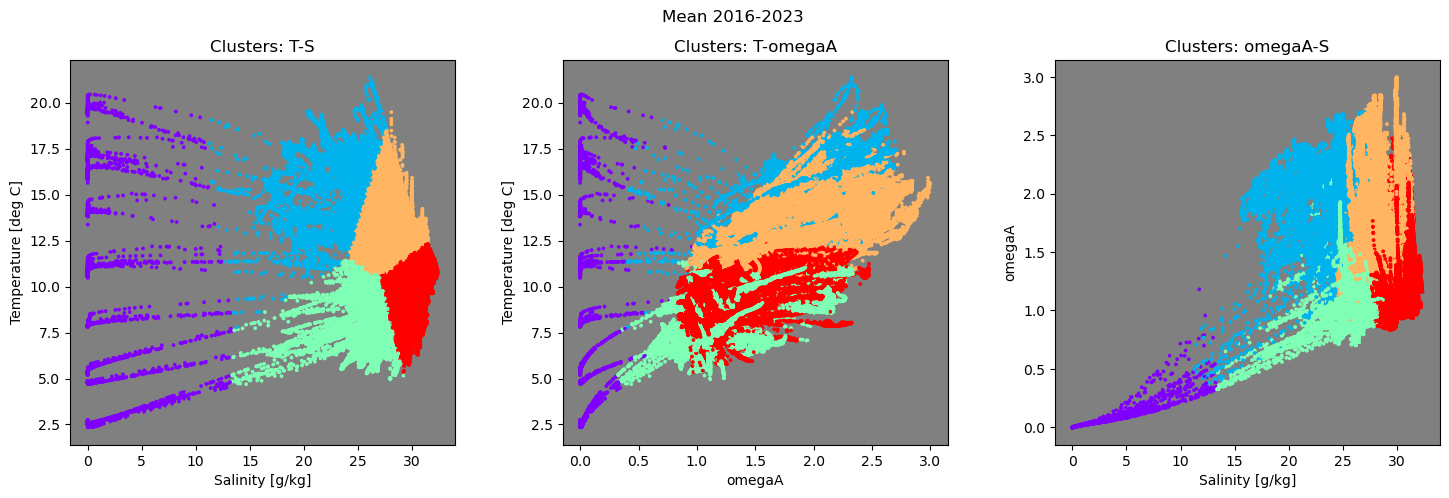

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,5), gridspec_kw={'width_ratios': [2,2,2]})
fig.suptitle('{} 2016-2023'.format('Mean'))

points = ax[0].scatter(salinity_vals_only, temperature_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=1)
ax[0].set_title('Clusters: T-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)
ax[0].set_facecolor('grey')

points = ax[1].scatter(omegaA_vals_only, temperature_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=1)
ax[1].set_title('Clusters: T-omegaA')
ax[1].set_xlabel('omegaA')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')

points = ax[2].scatter(salinity_vals_only, omegaA_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=1)
ax[2].set_title('Clusters: omegaA-S')
ax[2].set_xlabel('Salinity [g/kg]')
ax[2].set_ylabel('omegaA')
ax[2].set_box_aspect(1)
ax[2].set_facecolor('grey')

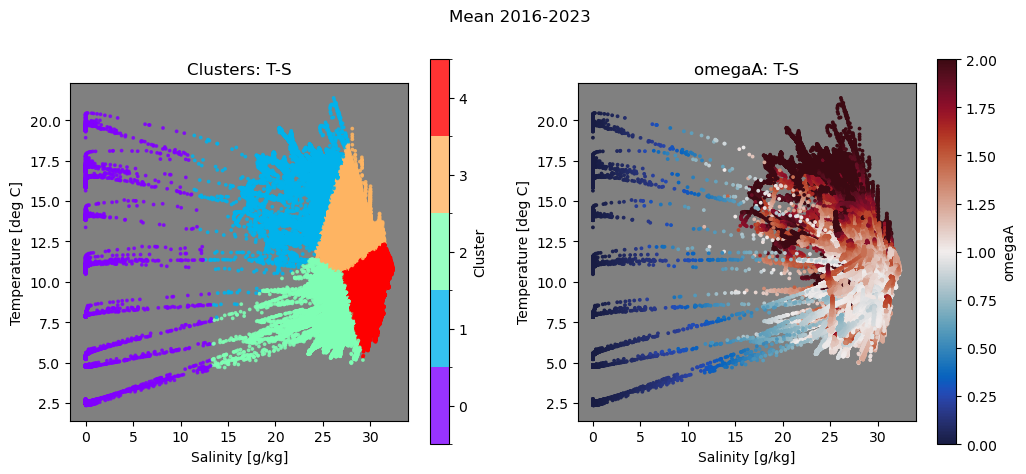

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5), gridspec_kw={'width_ratios': [1,1]})
fig.suptitle('{} 2016-2023'.format('Mean'))

points = ax[0].scatter(salinity_vals_only, temperature_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=0.8)
ax[0].set_title('Clusters: T-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)
ax[0].set_facecolor('grey')
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

points = ax[1].scatter(salinity_vals_only, temperature_vals_only, c=omegaA_vals_only, cmap=cm.balance, vmin=0, vmax=2, s=3)
ax[1].set_title('omegaA: T-S')
ax[1].set_xlabel('Salinity [g/kg]')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='omegaA')

### Same plot with tweaks for thesis

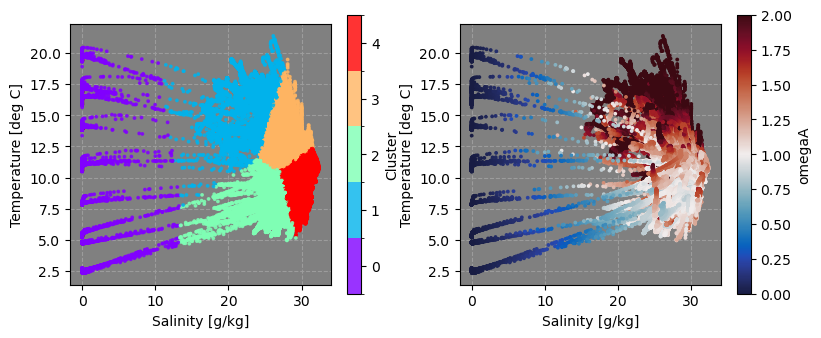

In [290]:
fig, ax = plt.subplots(1,2, figsize = (8,3.5), gridspec_kw={'width_ratios': [1,1]})
fig.tight_layout(pad=1.5)
# fig.suptitle('{} 2016-2023'.format('Mean'))

ax[0].grid(axis='y', color='#9c9c9c', linestyle='--', zorder=0)
ax[0].grid(axis='x', color='#9c9c9c', linestyle='--', zorder=0)
points = ax[0].scatter(salinity_vals_only, temperature_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=0.8, zorder=3)
# ax[0].set_title('Clusters: T-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)
ax[0].set_facecolor('grey')
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

ax[1].grid(axis='y', color='#9c9c9c', linestyle='--', zorder=0)
ax[1].grid(axis='x', color='#9c9c9c', linestyle='--', zorder=0)
points = ax[1].scatter(salinity_vals_only, temperature_vals_only, c=omegaA_vals_only, cmap=cm.balance, vmin=0, vmax=2, s=3, zorder=3)
# ax[1].set_title('omegaA: T-S')
ax[1].set_xlabel('Salinity [g/kg]')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='omegaA')


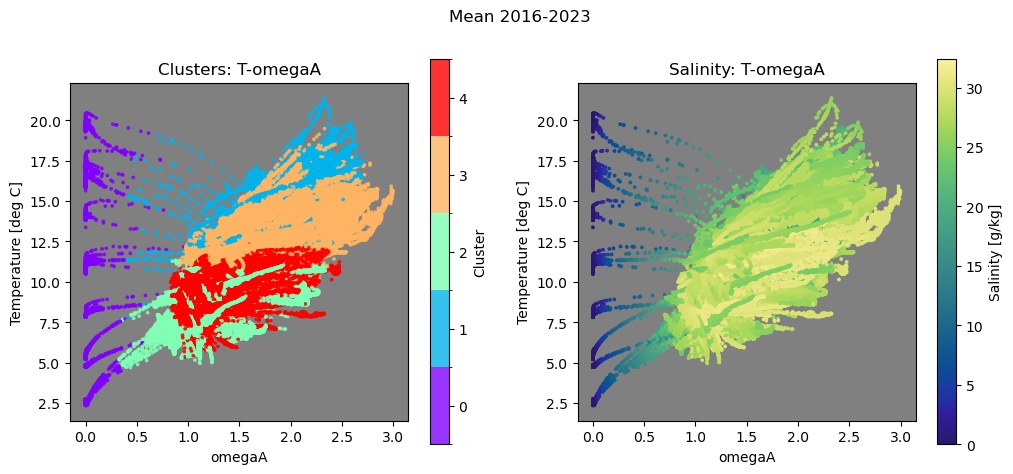

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5), gridspec_kw={'width_ratios': [1,1]})
fig.suptitle('{} 2016-2023'.format('Mean'))

points = ax[0].scatter(omegaA_vals_only, temperature_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=0.8)
ax[0].set_title('Clusters: T-omegaA')
ax[0].set_xlabel('omegaA')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)
ax[0].set_facecolor('grey')
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

points = ax[1].scatter(omegaA_vals_only, temperature_vals_only, c=salinity_vals_only, cmap=cm.haline, s=3)
ax[1].set_title('Salinity: T-omegaA')
ax[1].set_xlabel('omegaA')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='Salinity [g/kg]')

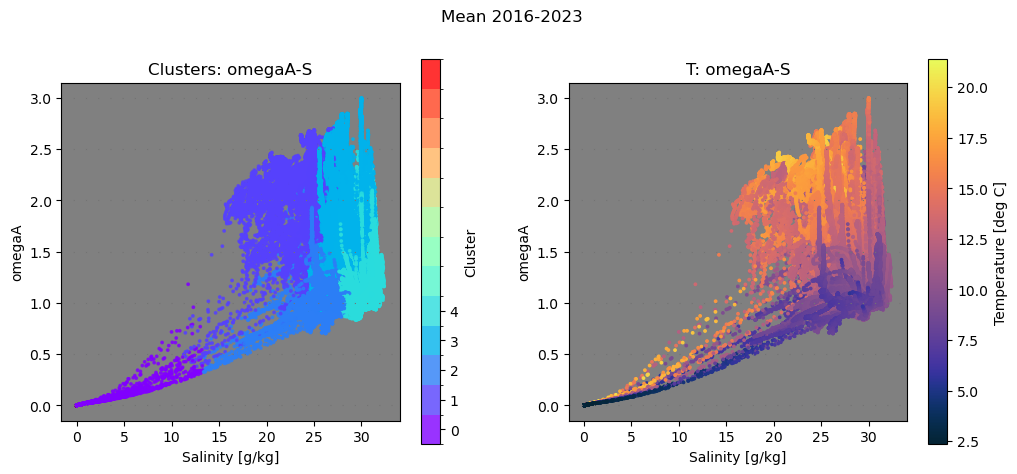

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5), gridspec_kw={'width_ratios': [1,1]})
fig.suptitle('{} 2016-2023'.format('Mean'))

points = ax[0].scatter(salinity_vals_only, omegaA_vals_only, c=clusters_months_flat, cmap=cmap, norm=norm_clusters, s=3, alpha=0.8)
ax[0].set_title('Clusters: omegaA-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('omegaA')
ax[0].set_box_aspect(1)
ax[0].set_facecolor('grey')
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

points = ax[1].scatter(salinity_vals_only, omegaA_vals_only, c=temperature_vals_only, cmap=cm.thermal, s=3)
ax[1].set_title('T: omegaA-S')
ax[1].set_xlabel('Salinity [g/kg]')
ax[1].set_ylabel('omegaA')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='Temperature [deg C]')

## Box plots

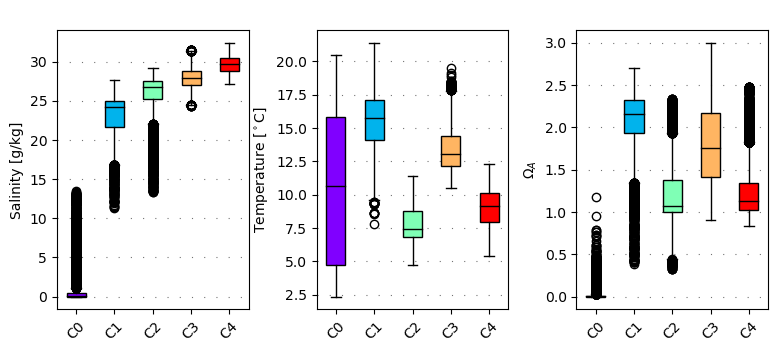

In [275]:
fig, ax = plt.subplots(1,3, figsize=(8,3.5))
# fig.suptitle('{} 2016-2023'.format('Mean'))
fig.tight_layout(pad=1.5)

# param_titles = ['Salinity', 'Temperature', 'omegaA']
param_titles = [' ', ' ', ' ']
param_units = ['Salinity [g/kg]', r'Temperature [$^\circ$C]', r'$\Omega_A$']

for i in range(3):
    boxplot = ax[i].boxplot(list_of_params[i], patch_artist=True)

    ax[i].set_title(param_titles[i])
    ax[i].set_ylabel(param_units[i])
    ax[i].set_xticks(range(1, n_clusters + 1))
    ax[i].set_xticklabels([f'C{j}' for j in range(0, n_clusters)], rotation=45)
    ax[i].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))

    for box, color in zip(boxplot['boxes'], cluster_colors):
        box.set_facecolor(color)
    
    for median in boxplot['medians']:
        median.set_color('black')
        median.set_linewidth(1)

## Summary plot

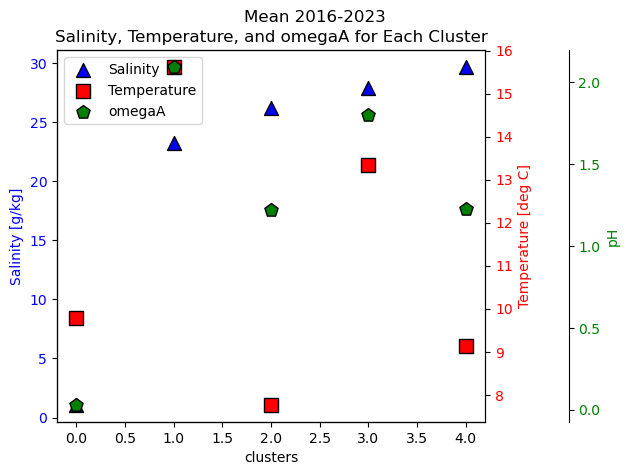

In [89]:
fig, ax1 = plt.subplots()
fig.suptitle('{} 2016-2023'.format('Mean'))

# salinity
scatter1 = ax1.scatter(range(n_clusters), salinity_means, color='b', label='salinity', marker='^', edgecolor='k', s=100, alpha=1)
ax1.set_xlabel('clusters')
ax1.set_ylabel('Salinity [g/kg]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(range(n_clusters), temperature_means, color='r', label='temperature', marker='s', edgecolor='k', s=100, alpha=1)
ax2.set_ylabel('Temperature [deg C]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# omegaA
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # move third y-axis outward
scatter3 = ax3.scatter(range(n_clusters), omegaA_means, color='g', label='omegaA', marker='p', edgecolor='k', s=100, alpha=1)
ax3.set_ylabel('pH', color='g')
ax3.tick_params(axis='y', labelcolor='g')

lines = [scatter1, scatter2, scatter3]
labels = ['Salinity', 'Temperature', 'omegaA']
ax1.legend(lines, labels)

fig.tight_layout()  # adjust layout to avoid overlap
plt.title('Salinity, Temperature, and omegaA for Each Cluster')
plt.show()